In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW 
from tqdm import tqdm

In [22]:
def eda_analysis(df):
    print("Первые 5 строк:")
    display(df.head())
    
    print("\nРаспределение классов Dangerous:")
    plt.figure(figsize=(6,4))
    sns.countplot(x='Dangerous', data=df)
    plt.show()
    
    print("\nРаспределение AnimalClass:")
    plt.figure(figsize=(8,4))
    sns.countplot(x='AnimalClass', data=df, hue='Dangerous')
    plt.show()
    
    print("\nПримеры текстов:")
    for i in range(3):
        print(f"{i+1}. {df['syptom_description'].iloc[i]}\n")

In [23]:
class SymptomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = [
            f"Животное: {row.AnimalClass}. Симптомы: {row.syptom_description}" 
            for _, row in df.iterrows()
        ]
        self.labels = df.Dangerous.values
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [24]:
class BERTDangerClassifier:
    def __init__(self, model_name='DeepPavlov/rubert-base-cased', n_classes=2, max_len=128):
        self.model = BertForSequenceClassification.from_pretrained(
            model_name, num_labels=n_classes)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.max_len = max_len
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
    def prepare_data(self, df):
        texts = [f"Животное: {row.AnimalClass}. Симптомы: {row.syptom_description}" 
                for _, row in df.iterrows()]
        labels = df.Dangerous.values
        return train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)
        
    def create_data_loader(self, df, batch_size=16):
        dataset = SymptomDataset(
            df=df,
            tokenizer=self.tokenizer,
            max_len=self.max_len
        )
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    def train(self, train_df, val_df, epochs=4, batch_size=16, learning_rate=2e-5):
        train_loader = self.create_data_loader(train_df, batch_size)
        val_loader = self.create_data_loader(val_df, batch_size)
        
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )
        
        best_f1 = 0
        for epoch in range(epochs):
            self.model.train()
            losses = []
            correct_predictions = 0
            
            for batch in tqdm(train_loader):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                logits = outputs.logits
                
                _, preds = torch.max(logits, dim=1)
                correct_predictions += torch.sum(preds == labels)
                losses.append(loss.item())
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            
            train_acc = correct_predictions.double() / len(train_loader.dataset)
            train_loss = np.mean(losses)
            
            val_acc, val_f1, val_loss = self.evaluate(val_loader)
            
            print(f'Epoch {epoch + 1}/{epochs}')
            print(f'Train loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')
            print(f'Val loss: {val_loss:.4f} Accuracy: {val_acc:.4f} F1: {val_f1:.4f}')
            
            if val_f1 > best_f1:
                torch.save(self.model.state_dict(), 'best_model.bin')
                best_f1 = val_f1
                
    def evaluate(self, data_loader):
        self.model.eval()
        losses = []
        correct_predictions = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                logits = outputs.logits
                
                _, preds = torch.max(logits, dim=1)
                correct_predictions += torch.sum(preds == labels)
                losses.append(loss.item())
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
        val_acc = correct_predictions.double() / len(data_loader.dataset)
        val_loss = np.mean(losses)
        val_f1 = f1_score(all_labels, all_preds)
        return val_acc, val_f1, val_loss
    
    def save_model(self, output_dir):
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        
    @classmethod
    def load_model(cls, model_path, max_len=128):
        model = BertForSequenceClassification.from_pretrained(model_path)
        tokenizer = BertTokenizer.from_pretrained(model_path)
        classifier = cls.__new__(cls)
        classifier.model = model
        classifier.tokenizer = tokenizer
        classifier.max_len = max_len
        classifier.device = torch.device('cpu')
        classifier.model.to(classifier.device)
        return classifier

In [25]:
df = pd.read_csv('final_dataset.csv').drop(columns=['Unnamed: 0'])

Первые 5 строк:


,AnimalClass,syptom_description,Dangerous
0,собака,"Высокая температура, Диарея, Рвота, Потеря вес...",1
1,собака,"Высокая температура, Диарея, Кашель, Усталость...",1
2,собака,"Высокая температура, Диарея, Кашель, Рвота, Ан...",1
3,собака,"Высокая температура, Трудности дыхание, Кашель...",1
4,собака,"Высокая температура, Диарея, Кашель, Летаргия,...",1



Распределение классов Dangerous:


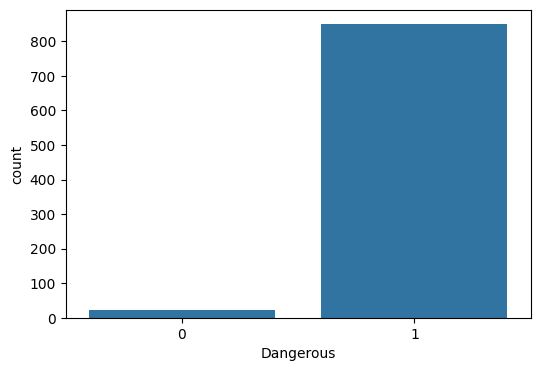


Распределение AnimalClass:


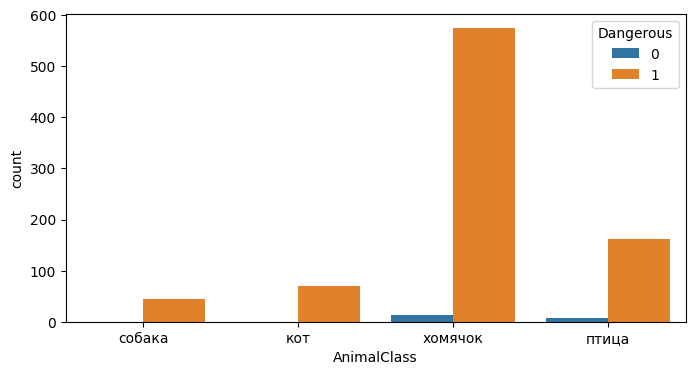


Примеры текстов:
1. Высокая температура, Диарея, Рвота, Потеря веса, Обезвоживание

2. Высокая температура, Диарея, Кашель, Усталость, Боли

3. Высокая температура, Диарея, Кашель, Рвота, Анорексия



In [26]:
eda_analysis(df)

In [27]:
train_df, test_df = train_test_split(
        df, test_size=0.2, stratify=df.Dangerous, random_state=42)

In [28]:
classifier = BERTDangerClassifier(max_len=256)
classifier.train(train_df, test_df, epochs=5, batch_size=8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 87/87 [13:44<00:00,  9.48s/it]


Epoch 1/5
Train loss: 0.1559 Accuracy: 0.9655
Val loss: 0.1178 Accuracy: 0.9771 F1: 0.9884


100%|██████████| 87/87 [13:35<00:00,  9.38s/it]


Epoch 2/5
Train loss: 0.1283 Accuracy: 0.9741
Val loss: 0.1173 Accuracy: 0.9771 F1: 0.9884


100%|██████████| 87/87 [13:26<00:00,  9.27s/it]


Epoch 3/5
Train loss: 0.1261 Accuracy: 0.9741
Val loss: 0.1231 Accuracy: 0.9771 F1: 0.9884


100%|██████████| 87/87 [13:21<00:00,  9.21s/it]


Epoch 4/5
Train loss: 0.1263 Accuracy: 0.9741
Val loss: 0.1077 Accuracy: 0.9771 F1: 0.9884


100%|██████████| 87/87 [13:14<00:00,  9.13s/it]


Epoch 5/5
Train loss: 0.0889 Accuracy: 0.9741
Val loss: 0.0729 Accuracy: 0.9771 F1: 0.9884


In [29]:
classifier.save_model('symptom_classifier')

In [30]:
loaded_model = BERTDangerClassifier.load_model('symptom_classifier')

In [61]:
def predict_danger(animal_class, description, threshold=0.995):
    text = f"Животное: {animal_class}. Симптомы: {description}"
    encoding = loaded_model.tokenizer.encode_plus(
        text,
        max_length=256,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(loaded_model.device)
    attention_mask = encoding['attention_mask'].to(loaded_model.device)
    
    with torch.no_grad():
        outputs = loaded_model.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    danger_prob = probs[0][1].item()
    
    is_dangerous = 1 if danger_prob >= threshold else 0
    
    return danger_prob, is_dangerous

In [67]:
example_animal = 'говно'
example_description = 'веселый добрый много кушает'
danger_prob, is_dangerous = predict_danger(example_animal, example_description)
print(f"Вероятность опасности: {danger_prob:.2f}")
print(f"Опасны ли симптомы: {'Да' if is_dangerous else 'Нет'}")

Вероятность опасности: 0.99
Опасны ли симптомы: Нет
